In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.constraints import max_norm
import matplotlib.pyplot as plt

from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope

tf.random.set_seed(1234)

In [2]:
def data_tranpose(df):
    """
    Transposing and resetting the index to train.
    :param df:
    :type df:
    :return:
    :rtype:
    """
    df = df.copy()
    df.drop(df.columns[0], axis=1, inplace=True)
    df.columns.values[0] = ""
    df.set_index(df.columns[0], inplace=True)

    df_output = df.transpose()
    df_output.reset_index(drop=True, inplace=True)
    df_output = df_output.astype("float32")

    return df_output

In [4]:
df_fitted = pd.read_csv("../forecasts/prison_arima_fitted.csv")
df_actual = pd.read_csv("../input_data/prison_actual.csv")
df_forecasts = pd.read_csv("../forecasts/prison_arima_forecasts.csv")

In [170]:
# df_actual_transpose['Aggregated']

In [87]:
#df_ets_forecasts = pd.read_csv("prison/prison_ets_forecasts.csv")

In [88]:
#df_forecasts.iloc[0,2:] = df_ets_forecasts.iloc[0,2:]

In [89]:
df_feature_tranpose = data_tranpose(df_fitted)
df_actual_transpose = data_tranpose(df_actual)
df_forecasts_transpose = data_tranpose(df_forecasts)

In [90]:
# df_fitted

In [91]:
df_feature_tranpose.index.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

In [92]:
df_feature_tranpose.shape

(40, 121)

In [93]:
df_actual_transpose.shape

(40, 121)

In [94]:
df_actual_transpose.head(5)

,Aggregated,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,ACT-Female,...,VIC-Male-Sentenced-ATSI,VIC-Male-Sentenced-Non-ATSI,WA-Female-Remanded-ATSI,WA-Female-Remanded-Non-ATSI,WA-Female-Sentenced-ATSI,WA-Female-Sentenced-Non-ATSI,WA-Male-Remanded-ATSI,WA-Male-Remanded-Non-ATSI,WA-Male-Sentenced-ATSI,WA-Male-Sentenced-Non-ATSI
0,24296.0,178.0,9018.0,785.0,5294.0,1552.0,525.0,3534.0,3410.0,7.0,...,126.0,2563.0,34.0,27.0,115.0,95.0,189.0,306.0,1057.0,1587.0
1,24643.0,183.0,9099.0,822.0,5345.0,1511.0,540.0,3592.0,3551.0,10.0,...,127.0,2623.0,24.0,28.0,114.0,102.0,186.0,332.0,1125.0,1640.0
2,24511.0,187.0,9007.0,796.0,5368.0,1530.0,529.0,3678.0,3416.0,6.0,...,146.0,2682.0,28.0,21.0,99.0,102.0,178.0,326.0,1070.0,1592.0
3,24393.0,204.0,8991.0,760.0,5321.0,1556.0,519.0,3649.0,3393.0,12.0,...,147.0,2658.0,19.0,24.0,97.0,96.0,181.0,307.0,1049.0,1620.0
4,24524.0,190.0,9103.0,806.0,5423.0,1536.0,476.0,3556.0,3434.0,13.0,...,151.0,2582.0,29.0,24.0,96.0,98.0,214.0,316.0,1013.0,1644.0


In [95]:
df_forecasts_transpose.shape

(8, 121)

In [96]:
df_forecasts_transpose.head(5)

,Aggregated,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,ACT-Female,...,VIC-Male-Sentenced-ATSI,VIC-Male-Sentenced-Non-ATSI,WA-Female-Remanded-ATSI,WA-Female-Remanded-Non-ATSI,WA-Female-Sentenced-ATSI,WA-Female-Sentenced-Non-ATSI,WA-Male-Remanded-ATSI,WA-Male-Remanded-Non-ATSI,WA-Male-Sentenced-ATSI,WA-Male-Sentenced-Non-ATSI
0,35238.511719,347.230774,10734.232422,1587.358887,7382.901855,2737.328125,437.392548,6568.919434,5444.671387,16.769266,...,364.974365,4327.782715,86.0,61.0,188.937164,189.418045,446.092316,648.564087,1432.727295,2375.884521
1,35845.503906,351.461548,10921.754883,1597.791138,7543.861328,2811.419678,457.783661,6708.636230,5514.964844,16.769266,...,370.948730,4373.406738,86.0,61.0,188.937164,191.809113,462.648041,657.128235,1432.727295,2384.769287
2,35965.027344,355.692322,10704.757812,1603.221069,7616.755371,2878.766113,463.600006,6884.341309,5552.009766,16.769266,...,376.923065,4434.993652,86.0,61.0,188.937164,194.200195,448.909576,665.692322,1432.727295,2389.183350
3,36649.531250,359.923065,10714.093750,1635.202515,7736.522949,2968.016846,470.778931,7139.030762,5620.917969,16.769266,...,382.897430,4518.208496,86.0,61.0,188.937164,196.591278,453.771149,674.256409,1432.727295,2391.375977
4,37260.101562,364.153839,10803.640625,1653.468994,7893.648438,3038.884766,438.178345,7274.526855,5659.290039,16.769266,...,388.871796,4521.605957,86.0,61.0,188.937164,198.982346,474.194580,682.820496,1432.727295,2392.465332


In [100]:
# upper level fitted time series
df_level1_ts = df_feature_tranpose.columns[0]
df_level2_ts = df_feature_tranpose.columns[1:9]
df_level3_ts = df_feature_tranpose.columns[9:(10+16-1)]
df_level4_ts = df_feature_tranpose.columns[25:(26+32-1)]
df_level5_ts = df_feature_tranpose.columns[57:(58+64-1)]

In [101]:
df_level3_ts

Index(['ACT-Female', 'ACT-Male', 'NSW-Female', 'NSW-Male', 'NT-Female',
       'NT-Male', 'QLD-Female', 'QLD-Male', 'SA-Female', 'SA-Male',
       'TAS-Female', 'TAS-Male', 'VIC-Female', 'VIC-Male', 'WA-Female',
       'WA-Male'],
      dtype='object', name='')

In [102]:
len(df_level5_ts)

64

In [103]:
matching_level1_indexes = {}

In [104]:
matching_level1_indexes[0] = np.arange(57,121).tolist()

In [105]:
matching_level1_indexes

{0: [57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120]}

In [106]:
matching_level2_indexes = {}

In [107]:
matching_level2_bottom_split = [i.split('-', 1)[0] for i in df_level5_ts]

In [108]:
# matching_level2_bottom_split

In [109]:
for var in range(1,9):
    match_name = df_feature_tranpose.columns[var]
    indices = [i for i, s in enumerate(matching_level2_bottom_split) if match_name in s]
    matching_level2_indexes[var] = [x+57 for x in indices]

In [110]:
matching_level2_indexes

{1: [57, 58, 59, 60, 61, 62, 63, 64],
 2: [65, 66, 67, 68, 69, 70, 71, 72],
 3: [73, 74, 75, 76, 77, 78, 79, 80],
 4: [81, 82, 83, 84, 85, 86, 87, 88],
 5: [89, 90, 91, 92, 93, 94, 95, 96],
 6: [97, 98, 99, 100, 101, 102, 103, 104],
 7: [105, 106, 107, 108, 109, 110, 111, 112],
 8: [113, 114, 115, 116, 117, 118, 119, 120]}

In [111]:
# find_index

In [112]:
matching_level3_indexes = {}

In [113]:
matching_level3_bottom_split = ["-".join(i.split("-", 2)[:2]) for i in df_level5_ts]

In [114]:
for var in range(9,25):
    match_name = df_feature_tranpose.columns[var]
    indices = [i for i, s in enumerate(matching_level3_bottom_split) if match_name in s]
    matching_level3_indexes[var] = [x+57 for x in indices]

In [115]:
matching_level3_indexes

{9: [57, 58, 59, 60],
 10: [61, 62, 63, 64],
 11: [65, 66, 67, 68],
 12: [69, 70, 71, 72],
 13: [73, 74, 75, 76],
 14: [77, 78, 79, 80],
 15: [81, 82, 83, 84],
 16: [85, 86, 87, 88],
 17: [89, 90, 91, 92],
 18: [93, 94, 95, 96],
 19: [97, 98, 99, 100],
 20: [101, 102, 103, 104],
 21: [105, 106, 107, 108],
 22: [109, 110, 111, 112],
 23: [113, 114, 115, 116],
 24: [117, 118, 119, 120]}

In [116]:
matching_level4_indexes = {}

In [117]:
matching_level4_bottom_split = ["-".join(i.split("-", 3)[:3]) for i in df_level5_ts]

In [118]:
for var in range(25,57):
    match_name = df_feature_tranpose.columns[var]
    indices = [i for i, s in enumerate(matching_level4_bottom_split) if match_name in s]
    matching_level4_indexes[var] = [x+57 for x in indices]

In [119]:
matching_level4_indexes

{25: [57, 58],
 26: [59, 60],
 27: [61, 62],
 28: [63, 64],
 29: [65, 66],
 30: [67, 68],
 31: [69, 70],
 32: [71, 72],
 33: [73, 74],
 34: [75, 76],
 35: [77, 78],
 36: [79, 80],
 37: [81, 82],
 38: [83, 84],
 39: [85, 86],
 40: [87, 88],
 41: [89, 90],
 42: [91, 92],
 43: [93, 94],
 44: [95, 96],
 45: [97, 98],
 46: [99, 100],
 47: [101, 102],
 48: [103, 104],
 49: [105, 106],
 50: [107, 108],
 51: [109, 110],
 52: [111, 112],
 53: [113, 114],
 54: [115, 116],
 55: [117, 118],
 56: [119, 120]}

In [120]:
df_feature_tranpose.head(5)

,Aggregated,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,ACT-Female,...,VIC-Male-Sentenced-ATSI,VIC-Male-Sentenced-Non-ATSI,WA-Female-Remanded-ATSI,WA-Female-Remanded-Non-ATSI,WA-Female-Sentenced-ATSI,WA-Female-Sentenced-Non-ATSI,WA-Male-Remanded-ATSI,WA-Male-Remanded-Non-ATSI,WA-Male-Sentenced-ATSI,WA-Male-Sentenced-Non-ATSI
0,24271.703125,177.826233,9008.982422,784.233826,5291.632324,1551.305908,524.473083,3531.959717,3406.643311,6.993000,...,125.879974,2560.481445,33.966,26.973,114.885002,94.907394,188.817474,305.702576,1055.942993,1585.412964
1,24456.992188,182.230774,9041.748047,805.233093,5351.988770,1513.173950,539.456116,3591.042480,3482.317383,7.387423,...,131.974365,2611.741699,34.000,27.000,114.901596,97.544830,194.014450,314.564117,1062.202515,1594.003784
2,24753.003906,187.230774,9105.125000,837.381958,5388.567383,1491.045410,528.465210,3677.300537,3618.820068,8.616979,...,132.974365,2675.820801,24.000,28.000,113.304741,105.524025,190.246231,340.564117,1148.104004,1666.329956
3,24461.708984,191.230774,8980.875000,810.611938,5380.762207,1519.998901,518.473267,3649.917969,3346.844727,7.474558,...,151.974365,2719.242920,28.000,21.000,92.300476,103.458305,183.936325,334.564117,1037.984863,1568.154053
4,24455.775391,208.230774,9022.333984,780.926392,5331.057129,1549.878418,498.102631,3563.627686,3453.395752,9.486750,...,152.974365,2660.540283,19.000,24.000,99.241249,96.415283,191.545792,315.564117,1053.550781,1633.910156


In [121]:
df_actual_transpose.head(5)

,Aggregated,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,ACT-Female,...,VIC-Male-Sentenced-ATSI,VIC-Male-Sentenced-Non-ATSI,WA-Female-Remanded-ATSI,WA-Female-Remanded-Non-ATSI,WA-Female-Sentenced-ATSI,WA-Female-Sentenced-Non-ATSI,WA-Male-Remanded-ATSI,WA-Male-Remanded-Non-ATSI,WA-Male-Sentenced-ATSI,WA-Male-Sentenced-Non-ATSI
0,24296.0,178.0,9018.0,785.0,5294.0,1552.0,525.0,3534.0,3410.0,7.0,...,126.0,2563.0,34.0,27.0,115.0,95.0,189.0,306.0,1057.0,1587.0
1,24643.0,183.0,9099.0,822.0,5345.0,1511.0,540.0,3592.0,3551.0,10.0,...,127.0,2623.0,24.0,28.0,114.0,102.0,186.0,332.0,1125.0,1640.0
2,24511.0,187.0,9007.0,796.0,5368.0,1530.0,529.0,3678.0,3416.0,6.0,...,146.0,2682.0,28.0,21.0,99.0,102.0,178.0,326.0,1070.0,1592.0
3,24393.0,204.0,8991.0,760.0,5321.0,1556.0,519.0,3649.0,3393.0,12.0,...,147.0,2658.0,19.0,24.0,97.0,96.0,181.0,307.0,1049.0,1620.0
4,24524.0,190.0,9103.0,806.0,5423.0,1536.0,476.0,3556.0,3434.0,13.0,...,151.0,2582.0,29.0,24.0,96.0,98.0,214.0,316.0,1013.0,1644.0


In [122]:
df_final_labels = df_actual_transpose.copy()

In [123]:
57+64

121

In [124]:
# df_actual_transpose

In [125]:
# df_final_labels

In [126]:
X_train, X_valid, Y_train, Y_valid = train_test_split(df_feature_tranpose, df_final_labels, test_size=0.2, random_state=42)

In [127]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train))  # training set
X_valid = pd.DataFrame(scaler.transform(X_valid))  # validation set
df_feature_scaled_test = pd.DataFrame(scaler.transform(df_feature_tranpose))  # training set during testing
df_forecasts_scaled = pd.DataFrame(scaler.transform(df_forecasts_transpose))  # testing set

In [128]:
label_size = df_final_labels.iloc[:,57:].shape[1]

In [129]:
label_size

64

In [130]:
all_indexes = {**matching_level1_indexes, **matching_level2_indexes, **matching_level3_indexes, **matching_level4_indexes}

In [131]:
all_indexes

{0: [57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120],
 1: [57, 58, 59, 60, 61, 62, 63, 64],
 2: [65, 66, 67, 68, 69, 70, 71, 72],
 3: [73, 74, 75, 76, 77, 78, 79, 80],
 4: [81, 82, 83, 84, 85, 86, 87, 88],
 5: [89, 90, 91, 92, 93, 94, 95, 96],
 6: [97, 98, 99, 100, 101, 102, 103, 104],
 7: [105, 106, 107, 108, 109, 110, 111, 112],
 8: [113, 114, 115, 116, 117, 118, 119, 120],
 9: [57, 58, 59, 60],
 10: [61, 62, 63, 64],
 11: [65, 66, 67, 68],
 12: [69, 70, 71, 72],
 13: [73, 74, 75, 76],
 14: [77, 78, 79, 80],
 15: [81, 82, 83, 84],
 16: [85, 86, 87, 88],
 17: [89, 90, 91, 92],
 18: [93, 94, 95, 96],
 19: [97, 98, 99, 100],
 20: [101, 10

In [150]:
###### Model building
def custom_loss_fn(reconciliation_loss_lambda):
    def loss(data, y_pred):
        """
        Computes the custom loss for model training, given the actuals and predictions
        :param data:
        :type data:
        :param y_pred:
        :type y_pred:
        :return:
        :rtype:
        """
        rec_loss_list = list()
#         all_predictions = y_pred[:, :64]
        all_predictions = y_pred
        actual = data[:, 57:]
        print(data)
        # prediction error
        loss_fn = tf.losses.MeanSquaredError()
        prediction_error = loss_fn(actual, all_predictions)
        
        # Reconcilation error
        for key in all_indexes:
            higher_hie_index = key
            lower_hie_index = all_indexes[higher_hie_index]

            higher_hie_ts = tf.reshape(data[:, higher_hie_index], [-1, 1])
            higher_hie_ts_actual = higher_hie_ts
            
            lower_index = (lower_hie_index[0] - 57)
            high_index = (lower_hie_index[-1] - 57)

            lower_hie_ts = y_pred[:, lower_index: (high_index + 1)]
            lower_hie_ts_agg_pred = tf.reduce_sum(lower_hie_ts, axis=1, keepdims=True)
            recon_loss = tf.math.reduce_mean(tf.square(higher_hie_ts_actual - lower_hie_ts_agg_pred))
            rec_loss_list.append(recon_loss)

        recon_loss_agg = tf.reduce_sum(rec_loss_list)
        final_loss = prediction_error + reconciliation_loss_lambda* recon_loss_agg
        return final_loss
    return loss

In [142]:
def val_loss_fn(y_actual, y_pred):
    """
    Computes the error for the validation set
    :param y_actual:
    :type y_actual:
    :param y_pred:
    :type y_pred:
    :return:
    :rtype:
    """
    val_loss = np.mean(np.sqrt(tf.losses.MSE(y_actual.values[:, 57:], y_pred)))
    return val_loss

In [159]:
def build_and_compile_model(hyperparams):
    """
    Specify an FFNN model given a specific hyperparameter config
    :return:
    :rtype:
    """
    tf.keras.backend.clear_session()  # destroy previously built models
    tf.random.set_seed(1234)  # set seed for reproducibility

    no_layers = hyperparams['no_layers']
    no_units_layer = hyperparams['no_units_layer']
    learning_rate = hyperparams['learning_rate']
    dropout_rate = hyperparams['dropout_rate']
    max_norm_value = hyperparams['max_norm_value']
    reconciliation_loss_lambda = hyperparams['reconciliation_loss_lambda']

    inputs = keras.Input(shape=df_feature_tranpose.shape[1])
    last_output = inputs
    for layer in range(no_layers):
        layer_output = layers.Dense(no_units_layer[layer],
                                   kernel_constraint=max_norm(max_norm_value))(last_output)
        x = layers.BatchNormalization()(layer_output)
        x = keras.activations.relu(x)
        last_output = layers.Dropout(dropout_rate)(x)

    model_outputs = layers.Dense(label_size)(last_output)

    bottom_level_actual = (inputs[:, 57:] - tf.constant(scaler.min_[57:])) / tf.constant(scaler.scale_[57:])
    print(inputs[:, 57:].shape)

    outputs = tf.add(model_outputs, bottom_level_actual)  # skip connection from input to bypass the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss=custom_loss_fn(reconciliation_loss_lambda=reconciliation_loss_lambda),
                  optimizer=tf.keras.optimizers.Adam(learning_rate))
    return model

In [160]:
def plot_loss(history):
    """
    Plot the loss curves of the model
    :param history:
    :type history:
    :return:
    :rtype:
    """
    plt.plot(history.history['loss'], label='loss')
    # plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([100, 200])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
    plt.show()

In [161]:
def validate_model(hyperparams):
    """
    Build and train FFNN model and return the validation loss for hyperparameter
    tuning
    :param hyperparameters_config:
    :type hyperparameters_config:
    :return:
    :rtype:
    """
    hyperparams['no_layers'] = hyperparams['layers']['no_layers']
    hyperparams['no_units_layer'] = hyperparams['layers']['no_units_layer']

    hierac_model = build_and_compile_model(hyperparams)


    history = hierac_model.fit(
        X_train, Y_train,
        batch_size=hyperparams['batch_size'],
        epochs=hyperparams['epochs'],
        verbose=1
    )

    validation_predictions = hierac_model.predict(x=X_valid)
    val_loss = val_loss_fn(Y_valid, validation_predictions)

    # hist = pd.DataFrame(history.history)

    return val_loss

In [162]:
def test_model(hyperparams):
    """
    Testing of the model with the best hyperparameter config found
    :param best_hyperparams:
    :type best_hyperparams:
    :return:
    :rtype:
    """
    hyperparams['no_layers'] = int(hyperparams['layers'] + 1)
    hyperparams['no_units_layer'] = [int(hyperparams['no_units_layer_' + str(hyperparams['layers'] + 1) + "_" + str(j)])
                for j in range(1, (hyperparams['layers'] + 2))]
    hierac_model = build_and_compile_model(hyperparams)

    history = hierac_model.fit(
        df_feature_scaled_test, df_final_labels,
        batch_size=int(hyperparams['batch_size']),
        epochs=int(hyperparams['epochs']),
        verbose=1
    )

    plot_loss(history)

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist.head()

    # forward propagate the forecasts to get the adjusted forecasts
    adjusted_forecasts = hierac_model.predict(x=df_forecasts_scaled)
    return adjusted_forecasts

In [163]:
######## Tune hyperparameters
layers_upper = 5
layers_list = []
for i in range(1, (layers_upper + 1)):
    layer_dict = {
        'no_layers': i,
        'no_units_layer': [scope.int(hp.quniform('no_units_layer_' + str(i) + "_" + str(j), 1, 256, 1))
                          for j in range(1, (i+1))]
    }
    layers_list.append(layer_dict)

fspace = {
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.1),
    'layers': hp.choice('layers', layers_list),
    'batch_size': scope.int(hp.quniform('batch_size', 1, X_train.shape[0], 1)),
    'epochs': scope.int(hp.quniform('epochs', 10, 200, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
    'max_norm_value': hp.uniform('max_norm_value', 0, 10),
    'reconciliation_loss_lambda': hp.uniform('reconciliation_loss_lambda', 0.1, 0.9)
}

# layers_list

trials = Trials()
max_evals = 50
best = fmin(
    fn=validate_model,
    space=fspace,
    algo=tpe.suggest,
    trials=trials,
    max_evals=max_evals
)

(None, 64)                                                                                                                                                                                                                              
Epoch 1/55                                                                                                                                                                                                                              
Tensor("IteratorGetNext:1", shape=(None, 121), dtype=float32)                                                                                                                                                                           
Tensor("IteratorGetNext:1", shape=(None, 121), dtype=float32)                                                                                                                                                                           
1/2 [==============>...............]                                

2/2 [==============================]                                                                                                                                                                                                    
 - ETA: 0s - loss: 127942.6406                                                                                                                                                                                                          
                                                                                                                                                                                                                                       
2/2 [==============================]                                                                                                                                                                                                    
 - 0s 103ms/step - loss: 127942.6406                                 

KeyboardInterrupt: 

In [80]:
df_bottom_phie_ts = df_level5_ts

Epoch 1/187
2/2 [==============================] - 3s 3ms/step - loss: 183904.8490
Epoch 2/187
2/2 [==============================] - 0s 2ms/step - loss: 178835.8646
Epoch 3/187
2/2 [==============================] - 0s 3ms/step - loss: 183702.9948
Epoch 4/187
2/2 [==============================] - 0s 3ms/step - loss: 155507.4635
Epoch 5/187
2/2 [==============================] - 0s 2ms/step - loss: 164111.7865
Epoch 6/187
2/2 [==============================] - 0s 3ms/step - loss: 160910.9010
Epoch 7/187
2/2 [==============================] - 0s 2ms/step - loss: 153638.2448
Epoch 8/187
2/2 [==============================] - 0s 2ms/step - loss: 140447.5156
Epoch 9/187
2/2 [==============================] - 0s 2ms/step - loss: 140034.7969
Epoch 10/187
2/2 [==============================] - 0s 2ms/step - loss: 133279.7344
Epoch 11/187
2/2 [==============================] - 0s 2ms/step - loss: 130661.6927
Epoch 12/187
2/2 [==============================] - 0s 2ms/step - loss: 116642.7083
E

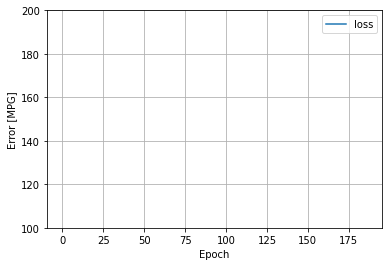

In [147]:
######### Test with the best hyperparameter combination
adjusted_forecasts = test_model(best)
adjusted_forecasts = pd.DataFrame(adjusted_forecasts)
adjusted_forecasts.columns = df_bottom_phie_ts
adjusted_forecasts = adjusted_forecasts.transpose()
output_file_name = "prison_arima/mse_ets2_forecasts_arima_prison_adjusted_fixed_forecasts_lambda_" + str(best['reconciliation_loss_lambda']) + ".csv"
adjusted_forecasts.to_csv(output_file_name)

best_config_df = pd.DataFrame(best)
best_config_file_name = "prison_arima/mse_ets2_forecasts_arima_best_config_fixed_lambda_" + str(best['reconciliation_loss_lambda']) + ".csv"
best_config_df.to_csv(best_config_file_name, index=False)

In [205]:
forecast = pd.read_csv('results/prison_arima_adjusted_forecasts.csv')

In [206]:
forecast = forecast.set_index(forecast.columns[0])

In [207]:
bottom_up_data = []
start_index_bottom_ts = 57
for key in all_indexes:
    hf_index = key
    low_ts = all_indexes[hf_index]
    lower_index = low_ts[0] - start_index_bottom_ts  # finding the index value starting from 0
    high_index = low_ts[-1] - start_index_bottom_ts
    ts_data= forecast.iloc[lower_index:(high_index+1),:].sum(axis=0)
    df = pd.DataFrame(ts_data)
    df.columns = [df_actual_transpose.columns[key]]
    bottom_up_data.append(df.transpose())

In [209]:
pd.concat(bottom_up_data).append(forecast)

,0,1,2,3,4,5,6,7
Aggregated,35431.646532,35709.197786,35646.477592,35850.194301,36083.373271,36241.774086,36248.998229,36420.609161
ACT,393.915884,397.623853,398.565119,401.544859,405.458729,408.932634,410.758639,413.336842
NSW,10792.168220,10882.437400,10713.257690,10707.909820,10800.114600,10802.704700,10684.426665,10674.914400
NT,1632.832300,1654.347652,1672.210762,1693.040843,1713.915455,1734.196847,1753.309797,1773.456209
QLD,7331.407420,7336.911186,7332.868180,7342.316690,7354.159246,7341.325620,7328.457690,7325.508460
...,...,...,...,...,...,...,...,...
WA-Female-Sentenced-Non-ATSI,195.559110,197.986080,200.221570,202.817800,205.508880,208.168350,210.513930,213.089100
WA-Male-Remanded-ATSI,460.506230,477.339800,463.657100,468.938100,490.079860,506.626220,493.958600,499.272520
WA-Male-Remanded-Non-ATSI,659.332100,668.123900,676.656300,685.607600,694.659550,703.627200,712.292600,721.144960
WA-Male-Sentenced-ATSI,1448.802500,1449.383500,1449.492000,1450.143400,1451.066400,1451.845300,1452.100500,1452.713900
